In [11]:
#Import everything
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import ternary
from scipy.stats import multinomial

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patches as mpatches

import index_haps as idh
import index_flow as idf

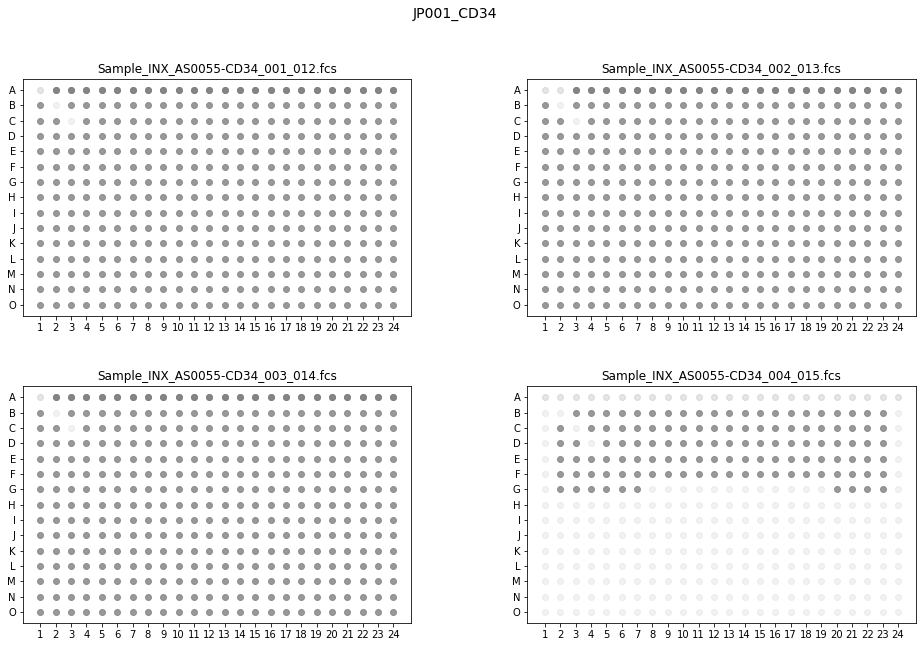

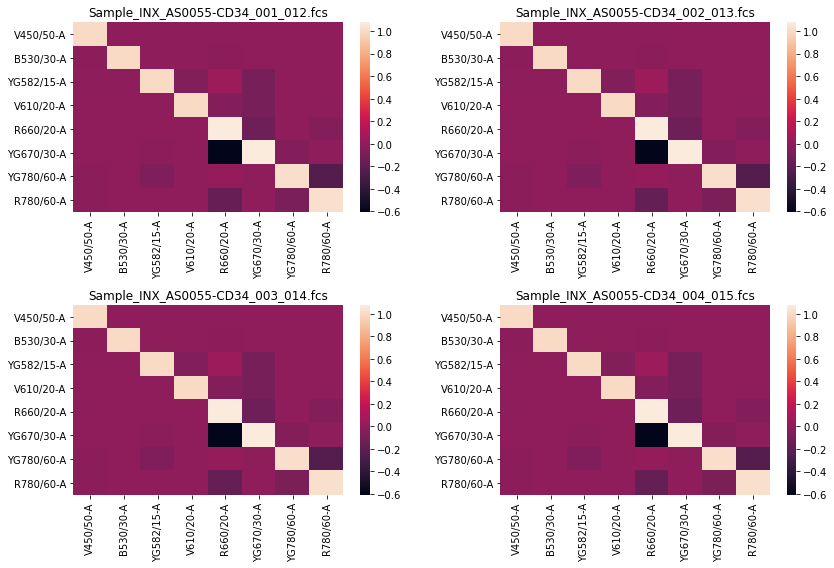

In [12]:
#JP001 CD34 parameters

directory = '../Data/JP001_BM/Indexed/'

#Make plate key - note one plate split over 2 index files
plate_key = {'Sample_INX_AS0055-CD34_001_012.fcs': 'not_seq',
             'Sample_INX_AS0055-CD34_002_013.fcs': 'AS-197',
             'Sample_INX_AS0055-CD34_003_014.fcs': 'AS-198',
             'Sample_INX_AS0055-CD34_004_015.fcs': 'AS-201'
            }

channel_key = {'YG582/15-A': 'CD34-PE', 
               'YG670/30-A': 'Lin-PE-Cy5', 
               'YG780/60-A': 'CD123-PE-Cy7', 
               'V450/50-A': 'CD90-BV421', 
               'V610/20-A': 'Zombie', 
               'B530/30-A': 'CD45RA-FITC', 
               'R660/20-A': 'IL1RAP-APC', 
               'R780/60-A': 'CD38-APC-cy7'
}

logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

plot_list = [
    ['FSC-A', 'SSC-A'],
    ['FSC-A', 'FSC-W'],
    ['SSC-A', 'SSC-H'],
    ['Zombie', 'Lin-PE-Cy5'], 
    ['CD34-PE', 'CD38-APC-cy7'],
    ['IL1RAP-APC', 'CD38-APC-cy7'],
    ['CD45RA-FITC', 'CD123-PE-Cy7'],
    ['CD45RA-FITC', 'CD90-BV421']
]
 
gates = {
    'Lin-PE-Cy5': 1000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 1100 ,  #Originally 2500, have adjusted to 1100 as per AS calculation for lowest 10%. 1300 ~15%. This is compatible with FlowJo analysis on total MNC
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 200,
    'Zombie': 8000,
    'IL1RAP-APC': 1400,  #set from FlowJo looking at FMOs
    'CD90-BV421': 500,
}



label = 'JP001_CD34'
idf.plate_qc(directory, label)
source = idf.get_comp_data(directory, plate_key, channel_key, plot = True)
#idf.flowplot_byplate(source, plot_list, logs, gates, label)


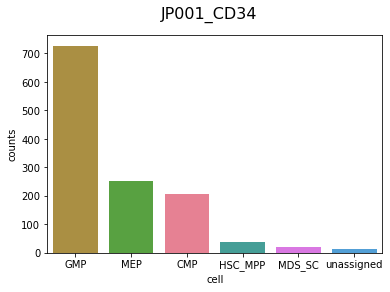

In [13]:
CD34assigned = idf.MDS_BM_celltype_assign(source, gates, label, save = False)

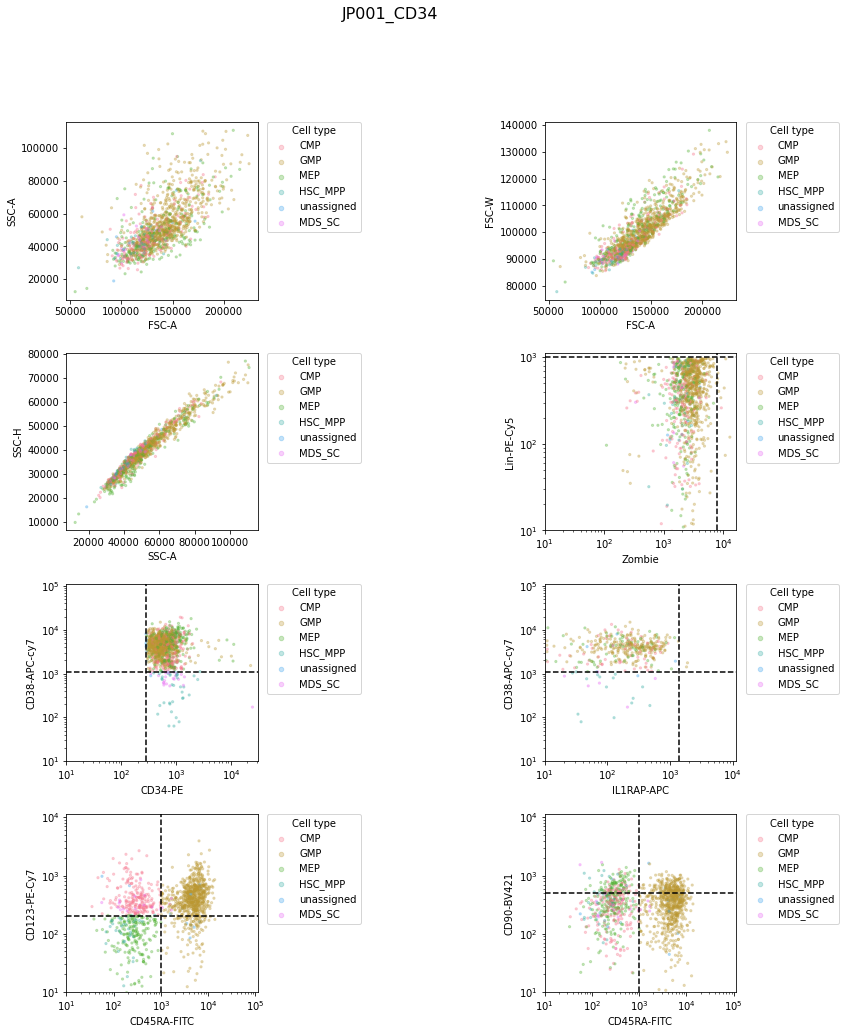

In [14]:
idf.flowplot_bycelltype(CD34assigned, plot_list, logs, gates,  label, plot = True, save = False)

In [63]:
def flowplot_bycelltype_gating(assigndata, logs, gates, data_name, plot = True, save = False):

	'''
	This function plots retrieved and compensated indexed fcs files, with colour applied according to the assigned cell type.
	To call = flowplot_bycelltype_gating(assigndata, logs, gates,  data_name, plot = True, save = False)
	assigndata is the dataframe containing the compensated index data, eg/ the output from MDS_BM_celltype_assign(), BM_celltype_assign(), PB_celltype_assign()
	logs is a list of channels which should be plotted on a log10 scale (eg/ all antibody channels)
	gates = a dictionary of gate locations for all relevant channels, these will be added to plots  eg/ gates = {'Lin-PE-Cy5': 1500}
	data_name is a string which will be used to customise the name of the output file {data_name}_flowplot_by_celltype.png
	When save = True, the plot will be saved in ../Results/
    '''

	sourcedata = assigndata.copy()
	sourcedata = sourcedata.loc[sourcedata['celltype'] != 'unassigned']    #don't plot unassigned cells
	plates = ['CMP','HSC_MPP','GMP', 'MDS_SC', 'MEP' ]
	cols = sns.color_palette('husl', n_colors = len(plates))
	palette = dict(zip(plates, cols))

	sourcedata['Colour'] = sourcedata['celltype'].map(palette)

#make the plots    
	fig = plt.figure(constrained_layout=True, figsize = (16, 3.5))
	gs = fig.add_gridspec(3, 4, height_ratios = [1,1,1], hspace = 0.1)
	ax0 = fig.add_subplot(gs[:,0])
	ax1 = fig.add_subplot(gs[:,1])
	ax2 = fig.add_subplot(gs[0:1,2])
	ax3 = fig.add_subplot(gs[1:2,2])
	ax4 = fig.add_subplot(gs[2:3,2])
	ax5 = fig.add_subplot(gs[0:,3])

#Populate each axis individually
	ax = ax0
	y = ['CD34-PE', 'CD38-APC-cy7']
	plot_data = sourcedata.copy()
	x_label = y[0]
	y_label = y[1]    
	ax.scatter(plot_data[x_label] + 11, plot_data[y_label] + 11, alpha = 0.3, c = plot_data['Colour'], s = 5)
	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)

	if x_label in logs:
		ax.set_xscale('log')
		ax.set_xlim(left = 10)
	if y_label in logs:
		ax.set_yscale('log')
		ax.set_ylim(bottom = 10)
	if x_label in gates:
		ax.axvline(gates[x_label] + 11, ls = '--', c = 'k')
	if y_label in gates:
		ax.axhline(gates[y_label] + 11, ls = '--', c = 'k')
	ax.autoscale_view()
        
	ax = ax1
	y = ['CD45RA-FITC', 'CD123-PE-Cy7']
	plot_data = sourcedata.loc[sourcedata['celltype'].isin(['CMP', 'GMP', 'MEP'])]
	x_label = y[0]
	y_label = y[1] 
	ax.scatter(plot_data[x_label] + 11, plot_data[y_label] + 11, alpha = 0.3, c = plot_data['Colour'], s = 5)
	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)

    
	if x_label in logs:
		ax.set_xscale('log')
		ax.set_xlim(left = 10)
	if y_label in logs:
		ax.set_yscale('log')
		ax.set_ylim(bottom = 10)
	if x_label in gates:
		ax.axvline(gates[x_label] + 11, ls = '--', c = 'k')
	if y_label in gates:
		ax.axhline(gates[y_label] + 11, ls = '--', c = 'k')
	ax.autoscale_view()
    
	ax = ax2
	y =  ['CD123-PE-Cy7', 'SSC-A']   
	plot_data = sourcedata.loc[sourcedata['celltype'].isin(['HSC_MPP', 'MDS_SC'])]
	x_label = y[0]
	y_label = y[1] 
	ax.scatter(plot_data[x_label] + 11, plot_data[y_label] + 11, alpha = 0.3, c = plot_data['Colour'], s = 5)
#	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)

	if x_label in logs:
		ax.set_xscale('log')
		ax.set_xlim(left = 10, right = 10000)
	if y_label in logs:
		ax.set_yscale('log')
		ax.set_ylim(bottom = 10)
	else:
		ax.set_ylim(bottom = 10000, top = 100000) 
		ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]) 
		ax.set_yticklabels([r'$10^4$','', '', '', '', '', '', '', '', r'$10^5$']) 
	if x_label in gates:
		ax.axvline(gates[x_label] + 11, ls = '--', c = 'k')
	if y_label in gates:
		ax.axhline(gates[y_label] + 11, ls = '--', c = 'k')
	ax.autoscale_view()
    
	ax = ax3
	y =  ['CD45RA-FITC', 'SSC-A']   
	plot_data = sourcedata.loc[sourcedata['celltype'].isin(['HSC_MPP', 'MDS_SC'])]
	x_label = y[0]
	y_label = y[1] 
	ax.scatter(plot_data[x_label] + 11, plot_data[y_label] + 11, alpha = 0.3, c = plot_data['Colour'], s = 5)
#	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)

	if x_label in logs:
		ax.set_xscale('log')
		ax.set_xlim(left = 10, right = 10000)
	if y_label in logs:
		ax.set_yscale('log')
		ax.set_ylim(bottom = 10)
	else:
		ax.set_ylim(bottom = 10000, top = 100000) 
		ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]) 
		ax.set_yticklabels([r'$10^4$','', '', '', '', '', '', '', '', r'$10^5$']) 
	if x_label in gates:
		ax.axvline(gates[x_label] + 11, ls = '--', c = 'k')
	if y_label in gates:
		ax.axhline(gates[y_label] + 11, ls = '--', c = 'k')
	ax.autoscale_view()
    
	ax = ax4
	y =  ['IL1RAP-APC', 'SSC-A']   
	plot_data = sourcedata.loc[sourcedata['celltype'].isin(['HSC_MPP', 'MDS_SC'])]
	x_label = y[0]
	y_label = y[1] 
	ax.scatter(plot_data[x_label] + 11, plot_data[y_label] + 11, alpha = 0.3, c = plot_data['Colour'], s = 5)
#	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)

	if x_label in logs:
		ax.set_xscale('log')
		ax.set_xlim(left = 10, right = 10000)
	if y_label in logs:
		ax.set_yscale('log')
		ax.set_ylim(bottom = 10)
	else:
		ax.set_ylim(bottom = 10000, top = 100000) 
		ax.set_yticks([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]) 
		ax.set_yticklabels([r'$10^4$','', '', '', '', '', '', '', '', r'$10^5$']) 
	if x_label in gates:
		ax.axvline(gates[x_label] + 11, ls = '--', c = 'k')
	if y_label in gates:
		ax.axhline(gates[y_label] + 11, ls = '--', c = 'k')
	ax.autoscale_view()

	ax = ax5
	y = ['CD45RA-FITC', 'CD90-BV421']
	plot_data = sourcedata.loc[sourcedata['celltype'].isin(['HSC_MPP', 'MDS_SC'])]
	x_label = y[0]
	y_label = y[1] 
	ax.scatter(plot_data[x_label] + 11, plot_data[y_label] + 11, alpha = 0.3, c = plot_data['Colour'], s = 5)
	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)

	for hap in palette:
		point = ax.scatter([], [], color=palette[hap], s = 20, alpha = 0.3, label=hap)
		ax.add_artist(point)
		ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,title='Cell type')
    
	if x_label in logs:
		ax.set_xscale('log')
		ax.set_xlim(left = 10, right = 10000)
	if y_label in logs:
		ax.set_yscale('log')
		ax.set_ylim(bottom = 10)
	if x_label in gates:
		ax.axvline(gates[x_label] + 11, ls = '--', c = 'k')
	if y_label in gates:
		ax.axhline(gates[y_label] + 11, ls = '--', c = 'k')
	ax.autoscale_view()
       

	plt.rcParams['svg.fonttype'] = 'none'  
	if save == True:
		fig.savefig(f'../Results/{data_name}_flowplot_by_celltype_gating.svg',dpi=600) 

	if plot == False:
		plt.close()        

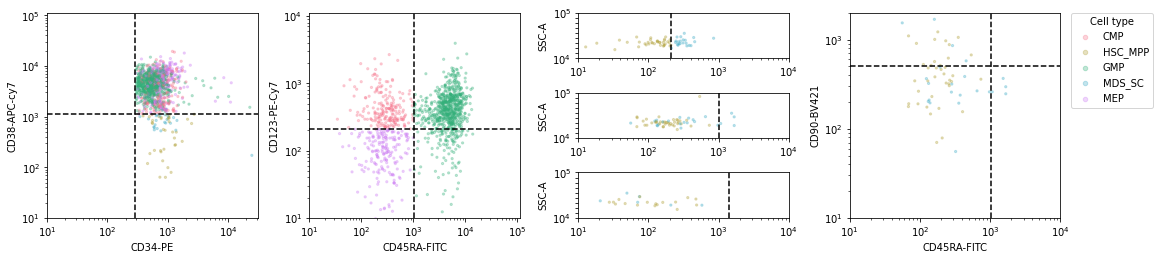

In [65]:
flowplot_bycelltype_gating(CD34assigned, logs, gates,  label, plot = True, save = True)